### Setup and Libraries

In [34]:
import pandas as pd
import numpy as np
import os, re, glob, sys
from pandas_profiling import ProfileReport
from datetime import datetime, timedelta
import string
PATH = "your_path_here"
DATA_PATH = os.path.join(PATH, "data")
REPORT_PATH = os.path.join(PATH,"reports")

In [3]:
df = pd.read_csv(os.path.join(DATA_PATH, "hotel_bookings.csv"))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
profile = ProfileReport(df, minimal=True)

In [6]:
profile.to_file(os.path.join(REPORT_PATH, "profiling.html"))

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 41.70it/s]


### Data Quality Quick Fix and Manipulation 

In [6]:
# might not be duplicate, just similar booking info attributes, watch out for 
# leakage later
df.duplicated().sum() 

31994

In [7]:
# data looks fine for statuses
df.groupby(['is_canceled','reservation_status'])['hotel'].count() 

is_canceled  reservation_status
0            Check-Out             75166
1            Canceled              43017
             No-Show                1207
Name: hotel, dtype: int64

In [7]:
df['arrival_date'] = df[['arrival_date_year','arrival_date_month','arrival_date_day_of_month']].\
    apply(lambda x: datetime.strptime('-'.join([str(x[0]), x[1], str(x[2])]),'%Y-%B-%d'), axis=1)


In [8]:
df['arrival_date_month_number'] = df.arrival_date.dt.month

In [9]:
df['arrival_day_in_week'] = df.arrival_date.dt.day_of_week

In [10]:
df['checkout_date'] = df[['is_canceled','stays_in_week_nights','stays_in_weekend_nights',
'arrival_date']].apply(lambda x: None if x[0] == 1 else x[3]+timedelta(days=x[1]+x[2]), axis=1)

In [11]:
df['checkout_day_in_week'] = df.checkout_date.dt.day_of_week

In [12]:
df['total_guest'] = df[['adults','children','babies']].sum(axis=1)

In [13]:
df['total_dependent'] = df[['children','babies']].sum(axis=1)

In [14]:
df['have_dependent'] = df.total_dependent.apply(lambda x:1 if x>0 else 0)

In [15]:
df['booking_date'] = df[['arrival_date','lead_time']].apply(lambda x: x[0] + timedelta(days=x[1]), axis=1)

In [16]:
df['booking_month'] = df.booking_date.dt.month

In [17]:
df['total_night'] = df[['stays_in_week_nights','stays_in_weekend_nights']].sum(axis=1)

In [18]:
# There are some customers didn't stay a night, might be only for short day stay?
df.loc[(df.is_canceled==0)&(df.total_night==0)].shape

(680, 43)

In [19]:
country_map = {'PRT':'EU', 'GBR':'EU', 'N.USA':'AMERICA', 'ESP':'EU', 
'IRL':'EU', 'FRA':'EU', 'ROU':'EU', 'NOR':'EU', 'OMN':'ASIA',
       'ARG':'S.USA', 'POL':'EU', 'DEU':'EU', 'BEL':'EU', 'CHE':'EU', 
       'CN':'N.USA', 'GRC':'EU', 'ITA':'EU', 'NLD':'EU',
       'DNK':'EU', 'RUS':'EU', 'SWE':'EU', 'AUS':'OCEANIA', 'EST':'EU', 
       'CZE':'EU', 'BRA':'S.USA', 'FIN':'EU', 'MOZ':'AFRICA',
       'BWA':'AFRICA', 'LUX':'EU', 'SVN':'EU', 'ALB':'EU', 'IND':'ASIA', 
       'CHN':'ASIA', 'MEX':'N.USA', 'MAR':'AFRICA', 'UKR':'EU',
       'SMR':'EU', 'LVA':'EU', 'PRI':'N.USA', 'SRB':'EU', 'CHL':'S.USA', 
       'AUT':'EU', 'BLR':'EU', 'LTU':'EU', 'TUR':'ASIA',
       'ZAF':'AFRICA', 'AGO':'AFRICA', 'ISR':'ASIA', 'CYM':'N.USA', 
       'ZMB':'AFRICA', 'CPV':'AFRICA', 'ZWE':'AFRICA', 'DZA':'AFRICA', 
       'KOR':'ASIA','CRI':'N.USA', 'HUN':'EU', 'ARE':'ASIA', 'TUN':'AFRICA', 'JAM':'N.USA', 
       'HRV':'EU', 'HKG':'ASIA', 'IRN':'ASIA', 'GEO':'ASIA',
       'AND':'EU', 'GIB':'EU', 'URY':'S.USA', 'JEY':'EU', 'CAF':'AFRICA', 
       'CYP':'ASIA', 'COL':'S.USA', 'GGY':'EU', 'KWT':'ASIA',
       'NGA':'AFRICA', 'MDV':'ASIA', 'VEN':'S.USA', 'SVK':'EU', 'FJI':'OCEANIA', 
       'KAZ':'ASIA', 'PAK':'ASIA', 'IDN':'ASIA', 'LBN':'ASIA',
       'PHL':'ASIA', 'SEN':'AFRICA', 'SYC':'AFRICA', 'AZE':'ASIA', 'BHR':'ASIA', 'NZL':'OCEANIA', 'THA':'ASIA', 'DOM':'N.USA', 'MKD':'EU',
       'MYS':'ASIA', 'ARM':'ASIA', 'JPN':'ASIA', 'LKA':'ASIA', 'CUB':'N.USA', 'CMR':'AFRICA', 'BIH':'EU', 'MUS':'AFRICA', 'COM':'AFRICA',
       'SUR':'S.USA', 'UGA':'AFRICA', 'BGR':'EU', 'CIV':'AFRICA', 'JOR':'ASIA', 'SYR':'ASIA', 'SGP':'ASIA', 'BDI':'AFRICA', 'SAU':'ASIA',
       'VNM':'ASIA', 'PLW':'OCEANIA', 'QAT':'ASIA', 'EGY':'AFRICA', 'PER':'S.USA', 'MLT':'EU', 'MWI':'AFRICA', 'ECU':'S.USA', 'MDG':'AFRICA',
       'ISL':'EU', 'UZB':'ASIA', 'NPL':'ASIA', 'BHS':'N.USA', 'MAC':'ASIA', 'TGO':'AFRICA', 'TWN':'ASIA', 'DJI':'AFRICA', 'STP':'AFRICA',
       'KNA':'N.USA', 'ETH':'AFRICA', 'IRQ':'ASIA', 'HND':'N.USA', 'RWA':'AFRICA', 'KHM':'ASIA', 'MCO':'EU', 'BGD':'ASIA', 'IMN':'EU',
       'TJK':'ASIA', 'NIC':'N.USA', 'BEN':'AFRICA', 'VGB':'N.USA', 'TZA':'AFRICA', 'GAB':'AFRICA', 'GHA':'AFRICA', 'TMP':'ASIA', 'GLP':'N.USA',
       'KEN':'AFRICA', 'LIE':'EU', 'GNB':'AFRICA', 'MNE':'EU', 'UMI':'OCEANIA', 'MYT':'AFRICA', 'FRO':'EU', 'MMR':'ASIA', 'PAN':'N.USA',
       'BFA':'AFRICA', 'LBY':'AFRICA', 'MLI':'AFRICA', 'NAM':'AFRICA', 'BOL':'S.USA', 'PRY':'S.USA', 'BRB':'N.USA', 'ABW':'N.USA', 'AIA':'N.USA',
       'SLV':'N.USA', 'DMA':'N.USA', 'PYF':'OCEANIA', 'GUY':'S.USA', 'LCA':'N.USA', 'ATA':'ANTARCTICA', 'GTM':'N.USA', 'ASM':'OCEANIA', 'MRT':'AFRICA',
       'NCL':'OCEANIA', 'KIR':'OCEANIA', 'SDN':'AFRICA', 'ATF':'AFRICA', 'SLE':'AFRICA', 'LAO':'ASIA',np.nan:None}

In [20]:
df['continent'] = df.country.map(country_map)

In [21]:
df['room_changed'] = df[['reserved_room_type','assigned_room_type']].apply(lambda x:0 if x[0]==x[1] else 1, axis=1)

In [77]:
df['reservation_status_date'] = df.reservation_status_date.apply(lambda x:datetime.strptime(x, "%Y-%m-%d"))

In [89]:
df['lead_time_to_cancel'] = df[['is_canceled','arrival_date','reservation_status_date']].apply(lambda x:None if x[0]==0 else (x[1] - x[2]).days, axis=1)

In [22]:
# There are 155 discrepancy rows where total guest is zero even customer didn't cancelled the booking, 
# removing from analysis
df.loc[(df.is_canceled==0)&(df.total_guest==0),['is_canceled','arrival_date','checkout_date','adults',
'children','babies', 'market_segment','reservation_status','reservation_status_date']]

,is_canceled,arrival_date,checkout_date,adults,children,babies,market_segment,reservation_status,reservation_status_date
2224,0,2015-10-06,2015-10-09,0,0.0,0,Corporate,Check-Out,2015-10-06
2409,0,2015-10-12,2015-10-12,0,0.0,0,Corporate,Check-Out,2015-10-12
3181,0,2015-11-20,2015-11-23,0,0.0,0,Groups,Check-Out,2015-11-23
3684,0,2015-12-30,2016-01-04,0,0.0,0,Groups,Check-Out,2016-01-04
3708,0,2015-12-30,2016-01-05,0,0.0,0,Groups,Check-Out,2016-01-05
...,...,...,...,...,...,...,...,...,...
115029,0,2017-06-27,2017-06-30,0,0.0,0,Online TA,Check-Out,2017-06-30
115091,0,2017-06-30,2017-07-01,0,0.0,0,Complementary,Check-Out,2017-07-01
116251,0,2017-07-15,2017-07-17,0,0.0,0,Online TA,Check-Out,2017-07-17
116534,0,2017-07-15,2017-07-22,0,0.0,0,Online TA,Check-Out,2017-07-22


In [23]:
df.drop(df.loc[(df.is_canceled==0)&(df.total_guest==0)].index, axis=0, inplace=True)

### Section 1 (Hotel Perspective)

1. Provide various descriptive analytics and insights
1. Suggest the use cases suitable here from the perspective of the hotel owner?

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

%matplotlib inline 

<AxesSubplot:>

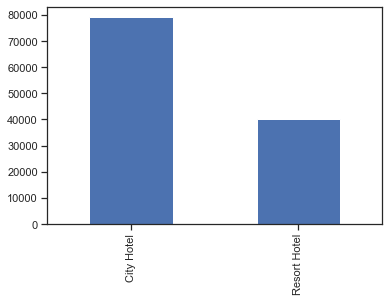

In [21]:
# There are two hotels - city and resort. From year 2015 to 2017, 
# bookings made on city hotel is higher than resort hotel 
df.hotel.value_counts().plot(kind='bar')

#### Q1.1 How is the booking process for customers? 

<AxesSubplot:xlabel='hotel,is_canceled'>

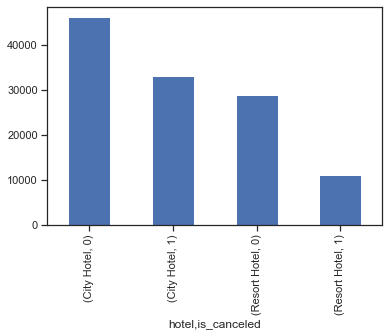

In [22]:
df.groupby(['hotel','is_canceled'])['lead_time'].count().plot(kind='bar')

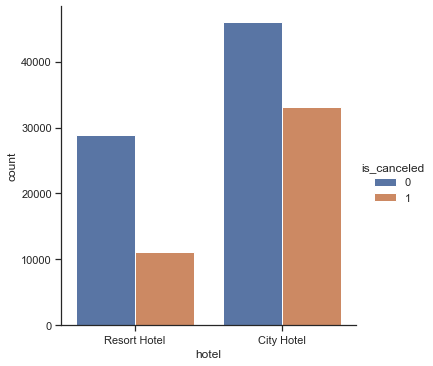

In [23]:
# however, the cancellation rate is also higher at city hotel 
# over these 2 years
sns.catplot(x='hotel', hue='is_canceled', kind='count',data=df)

In [24]:
df.arrival_date_year.value_counts()

2016    56636
2017    40631
2015    21968
Name: arrival_date_year, dtype: int64

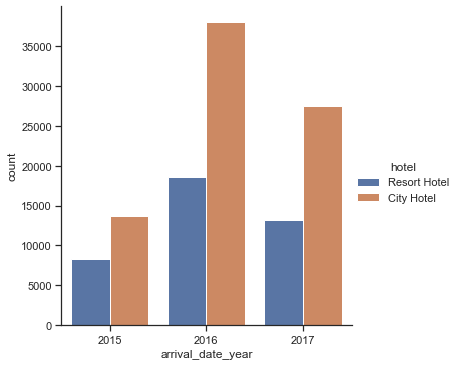

In [25]:
# 2016 is the year with highest bookings (2015-21968, 2016-56636, 2017-40631)
# the trend looks similar for both hotels
sns.catplot(x='arrival_date_year', hue='hotel', kind='count',data=df)

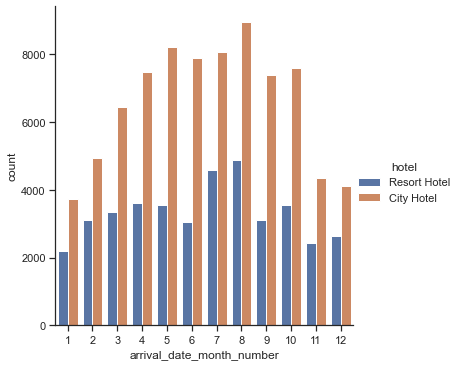

In [26]:
sns.catplot(x='arrival_date_month_number', hue='hotel', kind='count',
data = df)

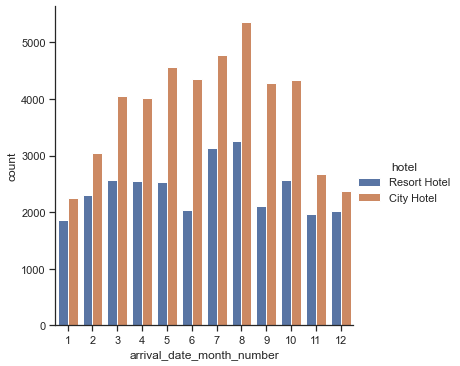

In [27]:
# Peak period in a year is around summer time, the hotels should be 
# based in Portugal (Europe) where people take 2-4 weeks annual leave 
# during summer. The trend stays the same for both hotels
sns.catplot(x='arrival_date_month_number', hue='hotel', kind='count',
data = df.loc[df.is_canceled==0])

<AxesSubplot:>

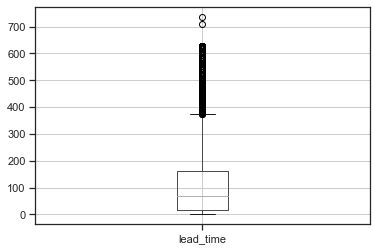

In [37]:
# Suppose the lead time between customer booking and entering to PMS system
# is negligible, the lead time between booking to arrival is around 2-3 months 
# on average
df[['lead_time']].boxplot()

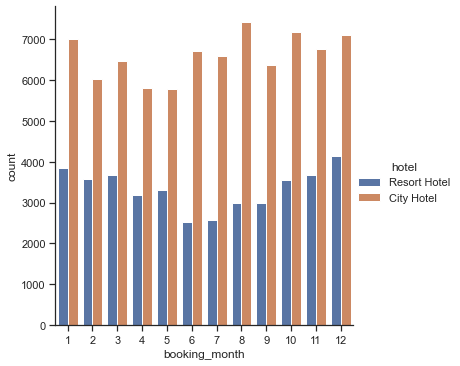

In [28]:
# People seems like start to plan or book hotel during winter time (Dec-Jan) 
# even there are some last mins booking as well
# The trend more obvious for resort hotel
sns.catplot(x='booking_month', hue='hotel', kind='count',
data = df)

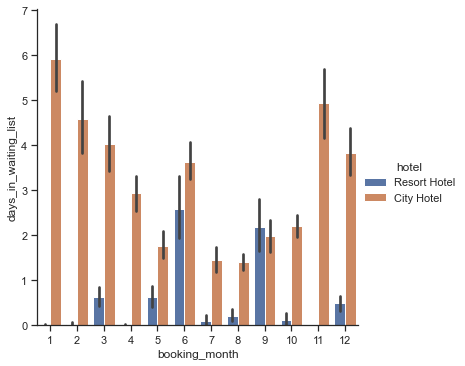

In [76]:
# There is only 3693 peoples under waiting list, city hotel seems to have longer waiting days esp on winter
sns.catplot(x='booking_month',y='days_in_waiting_list', hue='hotel', kind='bar',
data = df)

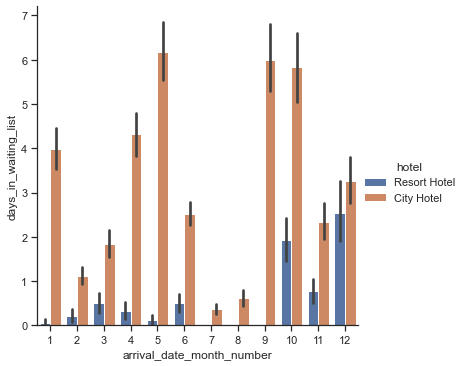

In [81]:
sns.catplot(x='arrival_date_month_number',y='days_in_waiting_list', hue='hotel', kind='bar',
data = df)

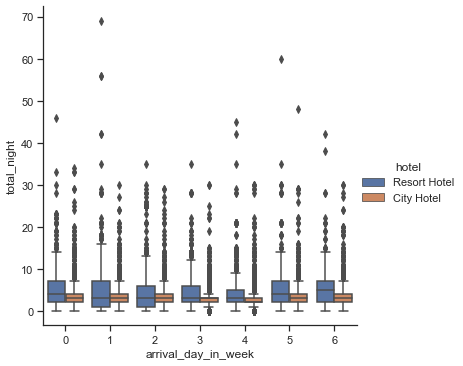

In [30]:
# On average, people stay for 3 nights, one night on weekend and 2 nights on 
# weekday. It seems like the spread is longer in resort hotel, and people 
# stay longer in resort on average
sns.catplot(x='arrival_day_in_week', y='total_night', hue='hotel',kind='box',
data=df)

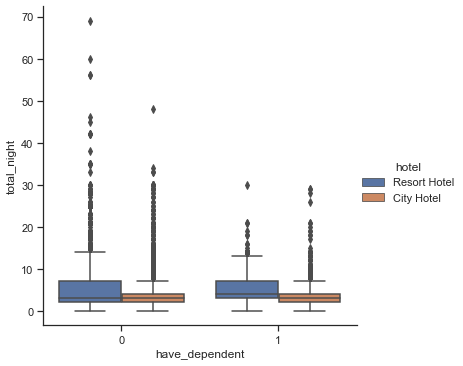

In [48]:
sns.catplot(x='have_dependent', y='total_night', hue='hotel',kind='box',
data=df)

<AxesSubplot:xlabel='hotel'>

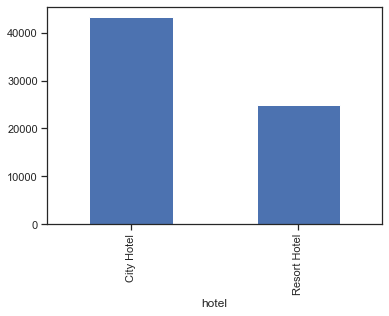

In [24]:
df.groupby('hotel')['total_of_special_requests'].sum().plot(kind='bar')

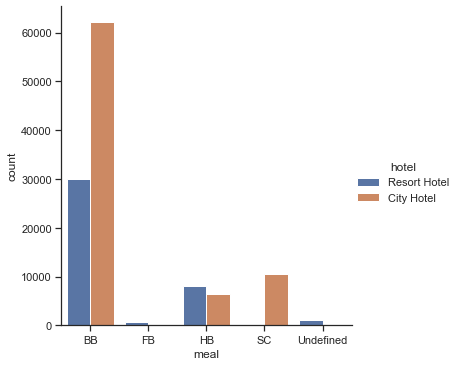

In [26]:
# Most customers opt for B&B
sns.catplot(x='meal', hue='hotel', kind='count',
data = df)

<AxesSubplot:xlabel='meal', ylabel='assigned_room_type'>

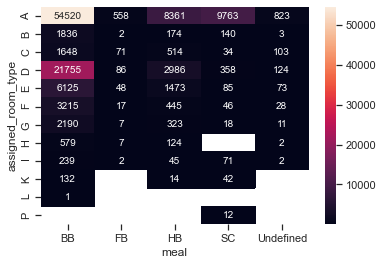

In [53]:
sns.heatmap(df.pivot_table("hotel","assigned_room_type", "meal", 
aggfunc='count'), annot=True, fmt='.0f')

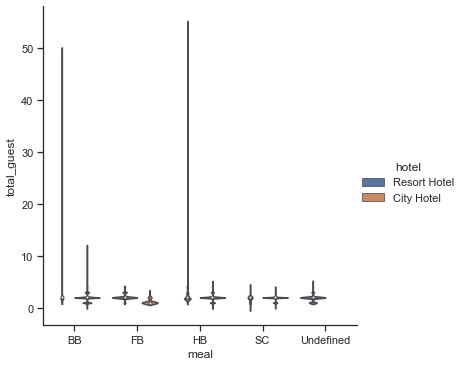

In [55]:
sns.catplot(x='meal', y='total_guest', hue='hotel',kind='violin',
data=df)

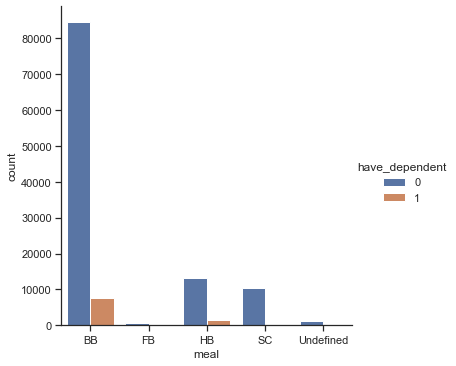

In [56]:
sns.catplot(x='meal', hue='have_dependent', kind='count',
data = df)

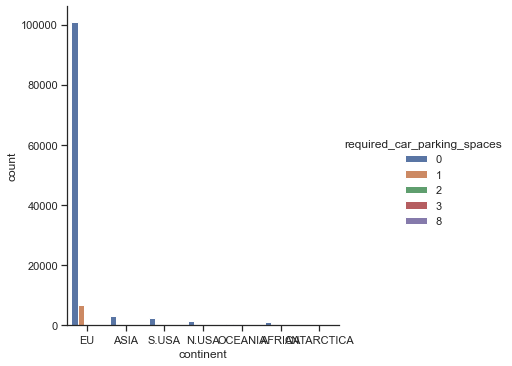

In [71]:
# Most customers don't require car park, but there is need for those in EU 
# (might be locals in Portugal)
sns.catplot(x='continent', hue='required_car_parking_spaces', kind='count', data =df)

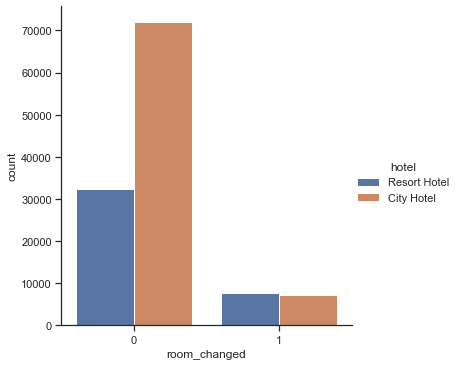

In [47]:
# Room change is prominent in resort
sns.catplot(x='room_changed', hue='hotel', kind='count',
data = df)

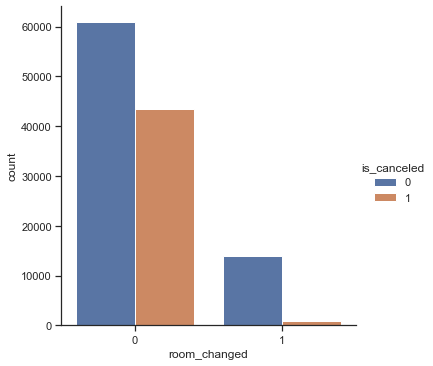

In [46]:
# Doesn't seem to lead to cancellation
sns.catplot(x='room_changed', hue='is_canceled', kind='count',
data = df)

<AxesSubplot:xlabel='assigned_room_type', ylabel='reserved_room_type'>

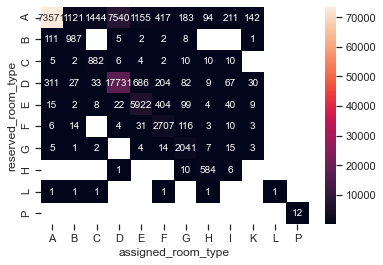

In [36]:
# high number of changes from room A to B-E
sns.heatmap(df.pivot_table("hotel","reserved_room_type", "assigned_room_type", 
aggfunc='count'), annot=True, fmt='.0f')

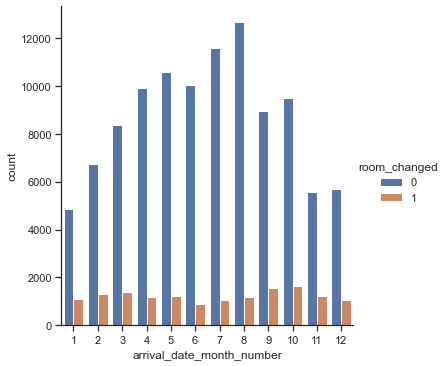

In [51]:
# Unlikely due to peak season, as the highest months are Feb-Mar, Sep-Oct
sns.catplot(x='arrival_date_month_number', hue='room_changed', kind='count',
data = df)

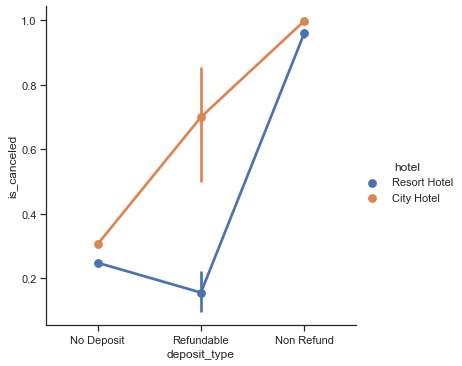

In [64]:
# For customers that pay in full or exceeded, there are high number of cancellation
sns.catplot(x='deposit_type', hue='hotel', y='is_canceled',kind='point',
data = df)

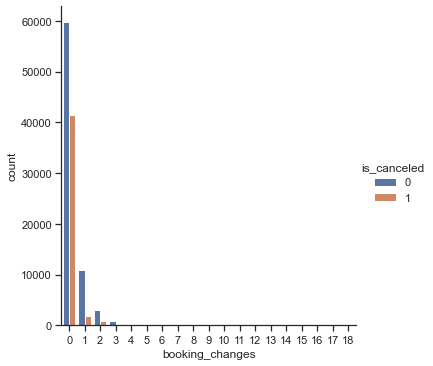

In [25]:
# Most people doesn't make booking changes
sns.catplot(x='booking_changes', hue='is_canceled', kind='count',
data = df)

In [29]:
# Most people doesn't have previous cancellation or previous realized bookings because
# most of them are not repeated customers
print((df.previous_bookings_not_canceled>0).sum())
print((df.previous_cancellations>0).sum())

3613
6481


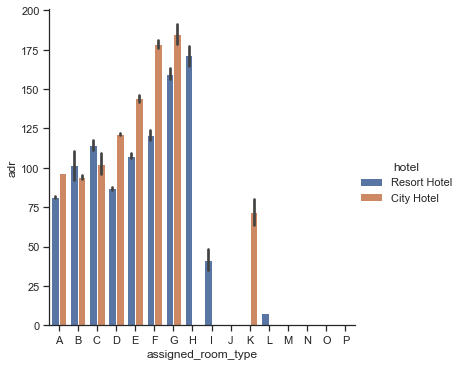

In [42]:
# There is one -ve adr might due to offer or discount or compensation to customers
# Nevertheless, on average customers paid RM 101 per day
# The rate seems to be higher for D-G in city than resort
sns.catplot(x='assigned_room_type', y='adr', hue='hotel', kind='bar',
data = df, order=[i for i in string.ascii_uppercase[:16]])


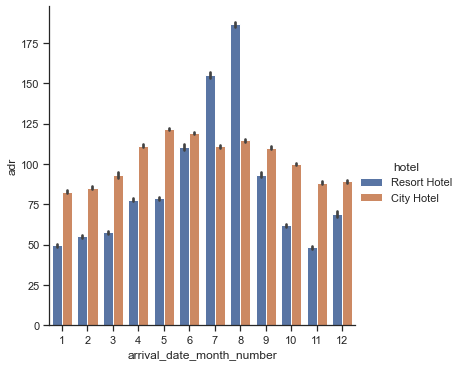

In [43]:
# Hotels charged premium during peak seasons
sns.catplot(x='arrival_date_month_number', y='adr', hue='hotel', kind='bar',
data = df)

<AxesSubplot:>

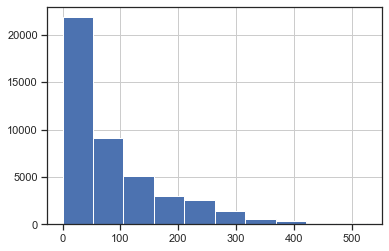

In [90]:
# On average hotels get cancellation notice between 50-85 days before arrival date
df.lead_time_to_cancel.hist()

#### Q1.2 Who are the customers?

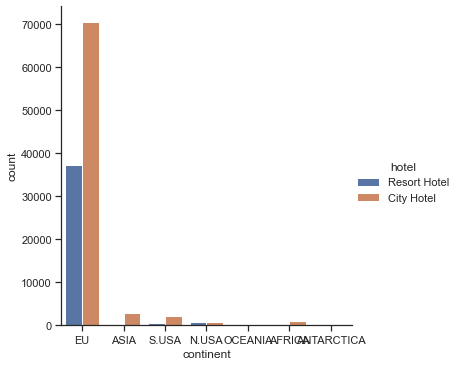

In [69]:
# most customers from EU (esp Portugal)
sns.catplot(x='continent', hue='hotel',kind='count',
data=df)

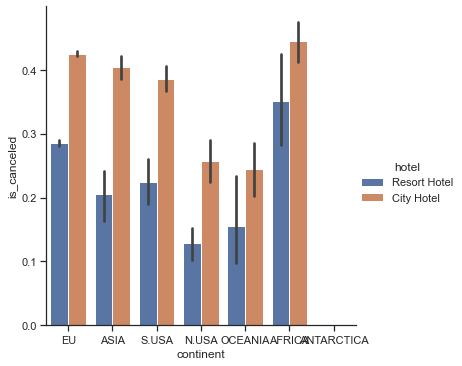

In [68]:
# Cancellation from African customers seems higher
# More effort to travel, less likely to cancel (Portugal quite near to Africa)
sns.catplot(x='continent',y='is_canceled', hue='hotel',kind='bar',
data=df)

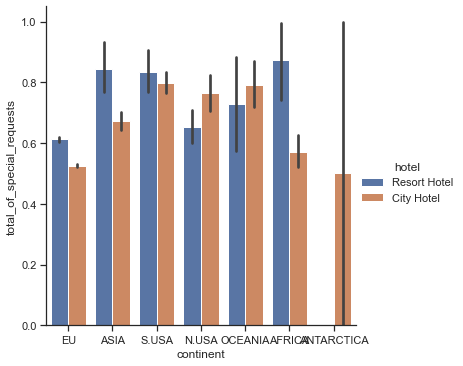

In [25]:
# EU customers seems to have less requests, maybe due to cultural difference for customer 
# from different continents 
sns.catplot(x='continent', y='total_of_special_requests', hue='hotel',kind='bar',
data=df)

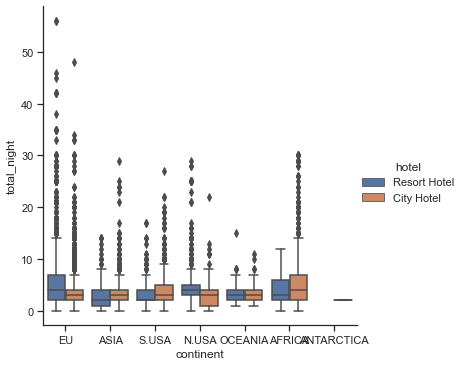

In [59]:
# Customer from Africa seems to stay longer
sns.catplot(x='continent', y='total_night', hue='hotel',kind='box',
data=df)

<AxesSubplot:xlabel='distribution_channel', ylabel='market_segment'>

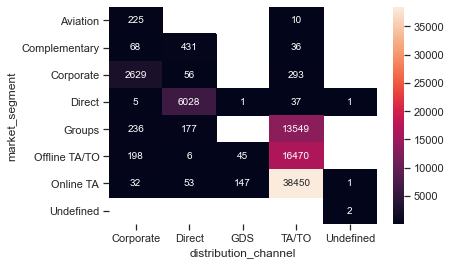

In [47]:
# majority of booking comes from TA/TO for city
sns.heatmap(df.loc[df.hotel=='City Hotel'].pivot_table("hotel","market_segment", "distribution_channel", 
aggfunc='count'), annot=True, fmt='.0f')

<AxesSubplot:xlabel='distribution_channel', ylabel='market_segment'>

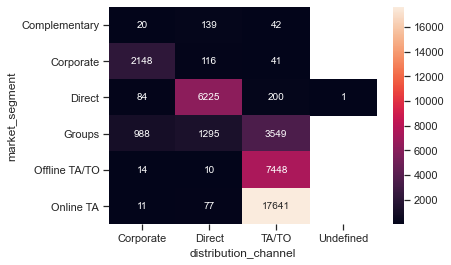

In [48]:
# majority of booking comes from TA/TO for resort
sns.heatmap(df.loc[df.hotel=='Resort Hotel'].pivot_table("hotel","market_segment", "distribution_channel", 
aggfunc='count'), annot=True, fmt='.0f')

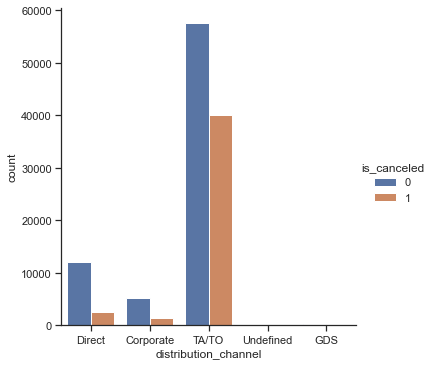

In [61]:
sns.catplot(x='distribution_channel', hue='is_canceled',kind='count',
data=df)

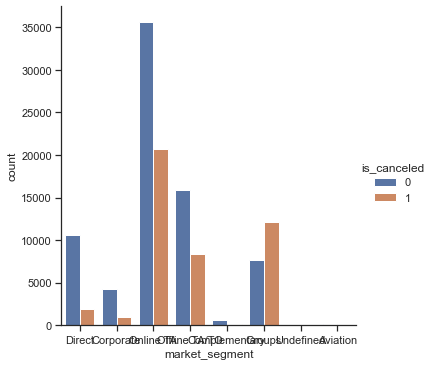

In [62]:
# Group cancellation is higher 
sns.catplot(x='market_segment', hue='is_canceled',kind='count',
data=df)

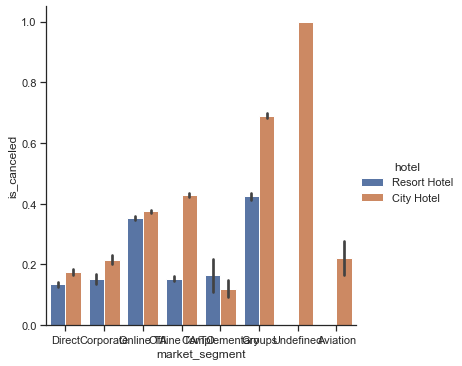

In [65]:
# Group and undefined cancellation is higher 
sns.catplot(x='market_segment', y='is_canceled', hue='hotel',kind='bar',
data=df)

In [49]:
# Most of the bookings are not from repeated customers
# Highest number of booking comes from agent #9 (31924), almost 30% of businesses comes from this agent
# Highest number of company booking comes from company #40 (924) that booked via offline TA
df.is_repeated_guest.value_counts()

0    115478
1      3757
Name: is_repeated_guest, dtype: int64

<AxesSubplot:>

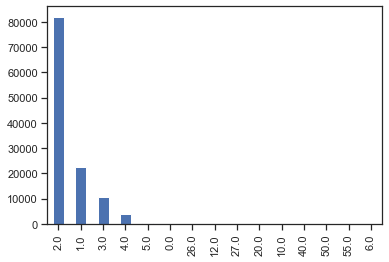

In [60]:
# Most of the time customers come in pairs
df.total_guest.value_counts().plot(kind='bar')

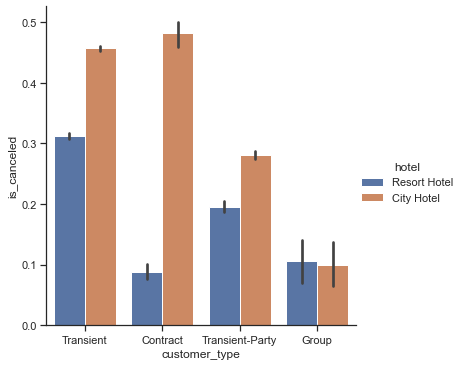

In [70]:
# Most bookings are transient, and cancellation for transient is also higher for resort, while contract 
# and transient cancelation is higher for city
sns.catplot(x='customer_type',y='is_canceled', hue='hotel', kind='bar',
data=df)

#### Q2 Use Cases for Hotels

Given analysis above,
1. Both hotels might want to consider to perform target marketing using market segmentation when people are considering travel during winter. 
1. The room packages could be bundled with other services (e.g. meals, travel tours) for cross-sell or up-sell purpose according to the customer attributes (e.g. couples, family, corporate).
1. Most of the customers are not repeated customers and they booked via 3rd party. While maintaining good relationsip with suppliers are good, hotels might want to consider to create loyalty program for certain customer segmentation esp corporate.
1. Hotel could perform yearly demand forecasting to better manage resources (e.g. hire part time or temporary workers) and increase occupancy during non-peak seasons.
1. Cancellation rate is 37%. If hotels could release some rooms for other bookings before x number of days, it could increase occupancy rate thus increase revenue.


### Section 2 (Guest Perspective)

#### Q3. Use Cases for Customers
Given analysis above, 
1. Customers might want to know when and how can they get the best deal by exploring their needs (e.g. couples or family, meal required, etc.). Forecasting could help customer to get best deal while also increase hotel occupancy.
1. Customer might have restricted budget but unsure what could be done, it might be good to have optimized options to maximize the use of their budget by customizing the bundle offered. Recommendation with optimization given selected parameters could be used to achieve this goal.

### Section 3 (Data Science)

#### Q4. Unsupervised

1. Customer persona could be established using customer demographics, purchase and interaction made, however we doesn't know whether each booking are unique
1. To eliminate leakage, duplicate observations are removed
1. Use `hotel`, `lead_time`, `arrival_date_month_number`, `booking_month`,`total_night`, `stays_in_week_nights`, `stays_in_weekend_nights`, `adults`, `babies`, `children`, `total_guest`, `meal`, `country`, `market_segment`, `distribution_channel`, `assigned_room_type`, `booking_changes`,`deposit_type`,`customer_type`, `adr`, `required_car_parking_spaces`, `total_of_special_requests`
`arrival_day_in_week`, `total_dependent`, `have_dependent`, `continent`, `lead_time_to_cancel`

In [253]:
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, Binarizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import silhouette_score, silhouette_samples
import pickle
SEED = 0

In [93]:
df_pca = df.drop_duplicates()

In [164]:
train_df, test_df = train_test_split(df_pca, random_state = SEED, test_size=0.2)

In [189]:
class prePCA(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.hotel_enc = OrdinalEncoder()
        self.continent_enc = OneHotEncoder(handle_unknown='ignore')
        self.meal_map = {'BB':1,'FB':3,'HB':2,'SC':0,'Undefined':-1}
        self.market_enc = OneHotEncoder(handle_unknown='ignore')
        # self.dist_enc = OneHotEncoder(handle_unknown='ignore')
        self.booking_enc = Binarizer()
        self.room_map = {'C':1, 'A':0, 'D':1, 'E':1, 'G':1, 
        'F':1, 'I':1, 'B':1, 'H':1, 'P':1, 'L':1, 'K':1}
        # self.room_enc = OneHotEncoder(handle_unknown='ignore')
        self.deposit_map = {'No Deposit':0, 'Non Refund':2, 'Refundable':1}
        self.customer_map = {'Transient':0, 'Contract':1, 'Transient-Party':1, 'Group':1}
        # self.customer_enc = OneHotEncoder(handle_unknown='ignore')
        self.request_enc = Binarizer()
        self.parking_enc = Binarizer()
        self.columns = ['hotel','continent','is_canceled','meal','lead_time',
        'market_segment','distribution_channel','booking_changes',
        'assigned_room_type','deposit_type','customer_type','have_dependent',
        'lead_time_to_cancel','total_of_special_requests',
        'required_car_parking_spaces','adr','booking_month',
        'arrival_date_month_number','total_night','stays_in_week_nights',
        'stays_in_weekend_nights','total_guest','arrival_day_in_week']

    def fit(self, X: pd.DataFrame):
        self.X = X 
        assert len(set(self.columns) - set(self.X.columns)) == 0
        self.X['continent'] = self.X.continent.fillna('UNK')
        self.X['lead_time_to_cancel'] = self.X.lead_time_to_cancel.fillna(-1)
        self.hotel_enc.fit(self.X.hotel.values.reshape(-1,1))
        self.continent_enc.fit(self.X.continent.values.reshape(-1,1))
        self.market_enc.fit(self.X.market_segment.values.reshape(-1,1))
        # self.dist_enc.fit(self.X.distribution_channel.values.reshape(-1,1))
        self.booking_enc.fit(self.X.booking_changes.values.reshape(-1,1))
        # self.room_enc.fit(self.X.assigned_room_type.values.reshape(-1,1))
        # self.customer_enc.fit(self.X.customer_type.values.reshape(-1,1))
        self.request_enc.fit(self.X.total_of_special_requests.values.reshape(-1,1))
        self.parking_enc.fit(self.X.required_car_parking_spaces.values.reshape(-1,1))

    def transform(self, X:pd.DataFrame, y=None):
        assert len(set(self.columns) - set(X.columns)) == 0
        X['continent'] = X.continent.fillna('UNK')
        X['lead_time_to_cancel'] = X.lead_time_to_cancel.fillna(-1)
        X['meal_map'] = X.meal.map(self.meal_map)
        X['deposit_map'] = X.deposit_type.map(self.deposit_map)
        X['room_binary'] = X.assigned_room_type.map(self.room_map)
        X['cust_binary'] = X.customer_type.map(self.customer_map)
        X['booking_binary'] = self.booking_enc.transform(X.booking_changes.values.reshape(-1,1))
        X['parking_binary'] = self.parking_enc.transform(X.required_car_parking_spaces.values.reshape(-1,1))
        X['request_binary'] = self.request_enc.transform(X.total_of_special_requests.values.reshape(-1,1))
        X['hotel_binary'] = self.hotel_enc.transform(X.hotel.values.reshape(-1,1))
        market_arr = self.market_enc.transform(X.market_segment.values.reshape(-1,1)).toarray()
        # dist_arr = self.dist_enc.transform(X.distribution_channel.values.reshape(-1,1)).toarray()
        # room_arr = self.room_enc.transform(X.assigned_room_type.values.reshape(-1,1)).toarray()
        # cust_arr = self.customer_enc.transform(X.customer_type.values.reshape(-1,1)).toarray()
        continent_arr = self.continent_enc.transform(X.continent.values.reshape(-1,1)).toarray()
        
        return pd.DataFrame(np.hstack((X[['is_canceled','lead_time','arrival_date_month_number','total_night',
        'arrival_day_in_week','meal_map','deposit_map','booking_binary', 
        'parking_binary','request_binary','lead_time_to_cancel','adr','have_dependent','total_guest',
        'hotel_binary','room_binary','cust_binary']], market_arr, continent_arr)),
        columns = ['is_canceled','lead_time','arrival_date_month_number','total_night','arrival_day_in_week',
        'meal_map','deposit_map','booking_binary', 'parking_binary',
        'request_binary','lead_time_to_cancel','adr','have_dependent','total_guest',
        'hotel_binary','room_binary','cust_binary'] + ['market_'+c for c in self.market_enc.categories_[0]] + 
        ['cont_'+c for c in self.continent_enc.categories_[0]]
        )


In [190]:
processor = prePCA()
processor.fit(train_df)

pca_train = processor.transform(train_df)
pca_test = processor.transform(test_df)

<ipython-input-189-53411d48aaa0>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.X['continent'] = self.X.continent.fillna('UNK')
<ipython-input-189-53411d48aaa0>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.X['lead_time_to_cancel'] = self.X.lead_time_to_cancel.fillna(-1)
<ipython-input-189-53411d48aaa0>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [191]:
scaler = StandardScaler()
pca = PCA(n_components = 10)
pca.fit_transform(scaler.fit_transform(pca_train))


array([[-7.75394525e-01, -1.42967336e+00, -7.88165978e-01, ...,
         2.27150722e-01,  1.29746262e+00,  7.74874857e-02],
       [-1.34192516e+00,  1.71721077e+00,  1.25577297e+00, ...,
        -1.52379634e+00,  9.08813235e-01, -4.94301765e-01],
       [ 3.71127094e-01,  1.15194667e+00,  1.20090766e-01, ...,
        -3.23587917e-01, -9.40701827e-02,  4.43417481e-01],
       ...,
       [-1.27816858e-01,  2.41108311e+00, -1.10584626e+00, ...,
         5.95094553e-01, -3.76764739e-01, -5.37465846e-01],
       [ 1.63593358e+00, -1.17762972e+00, -1.42230155e+00, ...,
         6.95568045e-05,  5.08517529e-01, -7.76369608e-01],
       [ 1.01952720e+00, -1.91870914e-01,  6.00253648e-01, ...,
         7.15096412e-01, -7.14434647e-03, -1.00640120e-01]])

In [193]:
pd.DataFrame(pca.components_.transpose(), columns = ['C_'+str(i) for i in range(1,11)],
index = pca_train.columns)

,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10
is_canceled,0.234146,0.215604,-0.334367,-0.027682,-0.278030,0.196966,-0.020617,-0.027263,-0.014205,0.056383
lead_time,0.057874,0.419142,-0.201082,0.107772,0.183374,-0.061676,-0.125450,0.021556,0.056467,-0.006829
arrival_date_month_number,0.014602,0.110944,0.025634,0.022790,0.081493,-0.105350,-0.044381,0.505087,0.193672,0.030187
total_night,0.044343,0.314668,0.023121,0.089493,0.311986,0.285472,-0.090302,-0.132922,0.133240,0.168014
arrival_day_in_week,0.059195,0.054888,0.020874,0.026599,0.085640,-0.088540,0.210605,-0.436364,-0.061424,-0.343208
meal_map,-0.076710,0.297035,0.236678,0.098765,0.018245,0.108950,-0.125103,0.068780,-0.034387,0.131005
deposit_map,-0.059722,0.189457,-0.229643,0.054832,-0.300227,-0.175806,-0.091653,0.017515,-0.125272,-0.117674
booking_binary,-0.105242,0.078717,0.140847,0.171291,0.001001,-0.325310,-0.070742,-0.046876,0.081540,0.268029
parking_binary,-0.031756,-0.047264,0.272586,0.016967,-0.087571,-0.086128,-0.363190,-0.026490,-0.025528,-0.028901
request_binary,0.205226,-0.107977,0.114168,-0.126981,0.364090,-0.179148,-0.252537,-0.055474,0.015289,-0.003886


For n_clusters = 2 The average silhouette_score is : 0.49184602022775664
For n_clusters = 4 The average silhouette_score is : 0.378366909131012
For n_clusters = 6 The average silhouette_score is : 0.3945003748912722
For n_clusters = 8 The average silhouette_score is : 0.34783410753026217
For n_clusters = 10 The average silhouette_score is : 0.3154389647480639
For n_clusters = 12 The average silhouette_score is : 0.3145454656025276
For n_clusters = 14 The average silhouette_score is : 0.3279312201410929
For n_clusters = 16 The average silhouette_score is : 0.3133510255463679
For n_clusters = 18 The average silhouette_score is : 0.30077294053219783
For n_clusters = 20 The average silhouette_score is : 0.31017975793068253


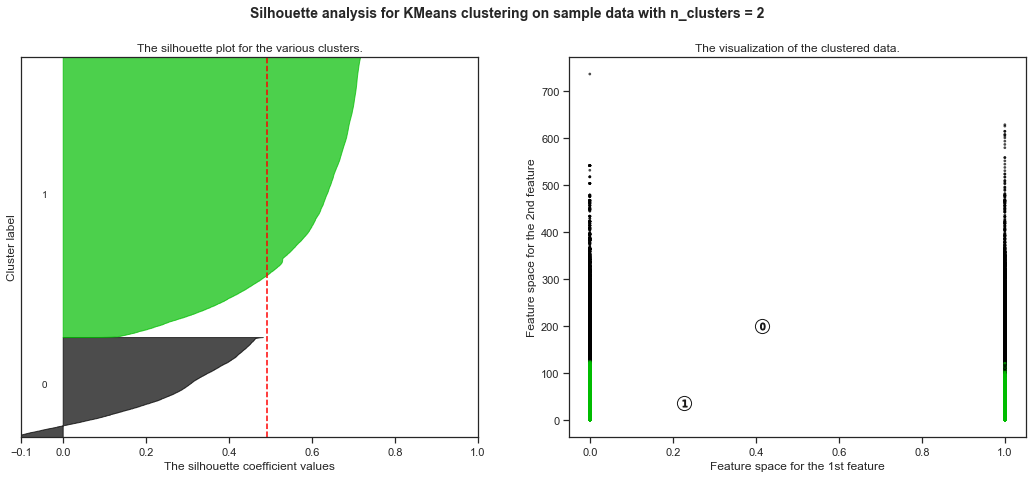

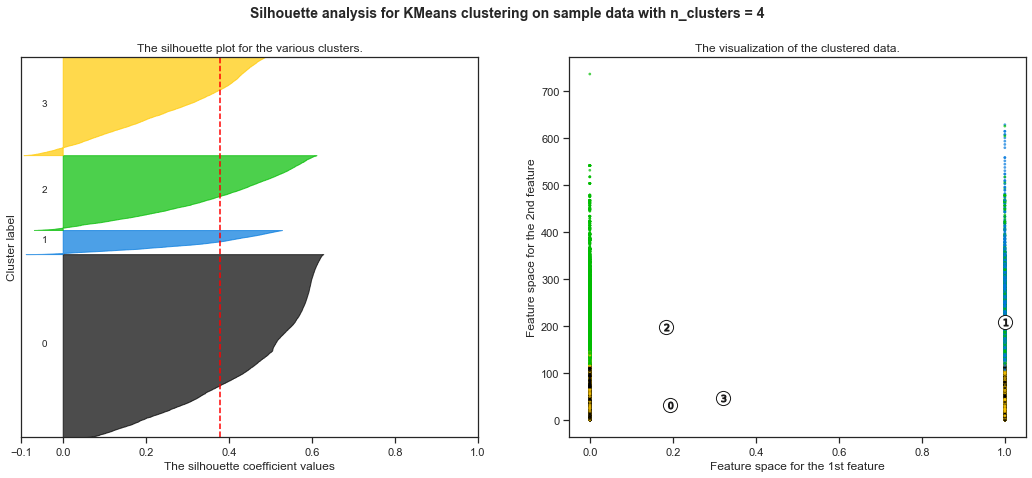

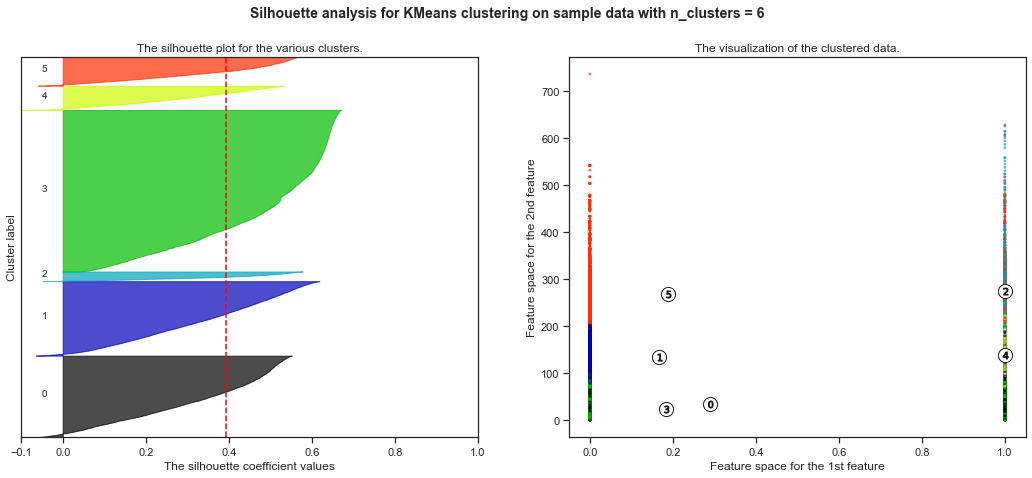

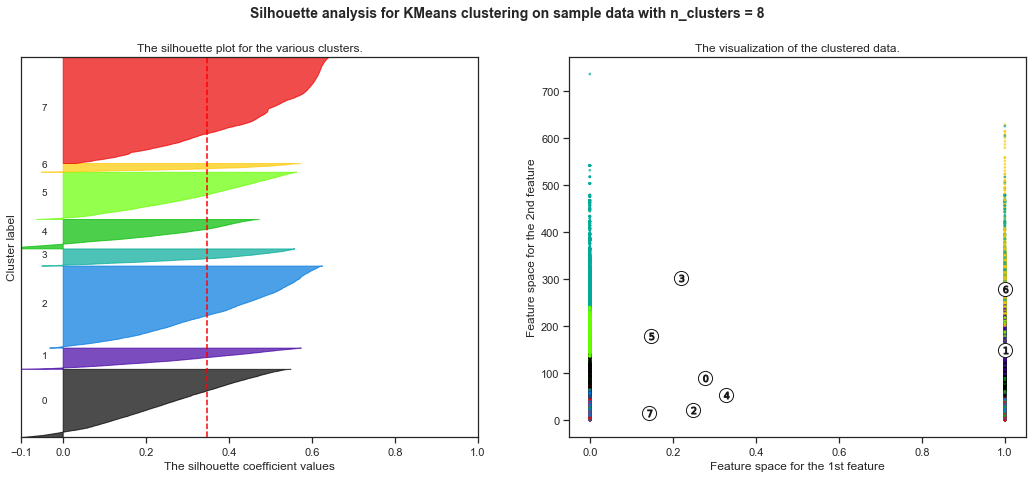

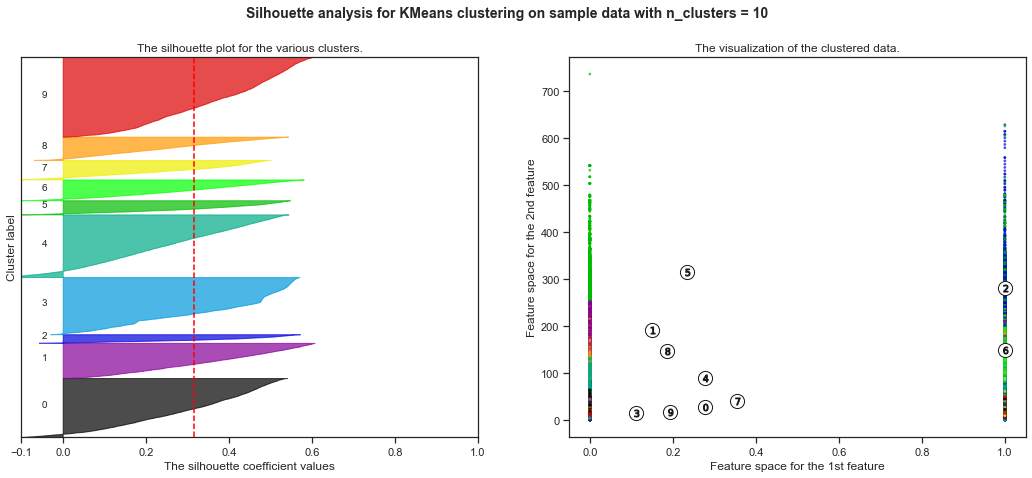

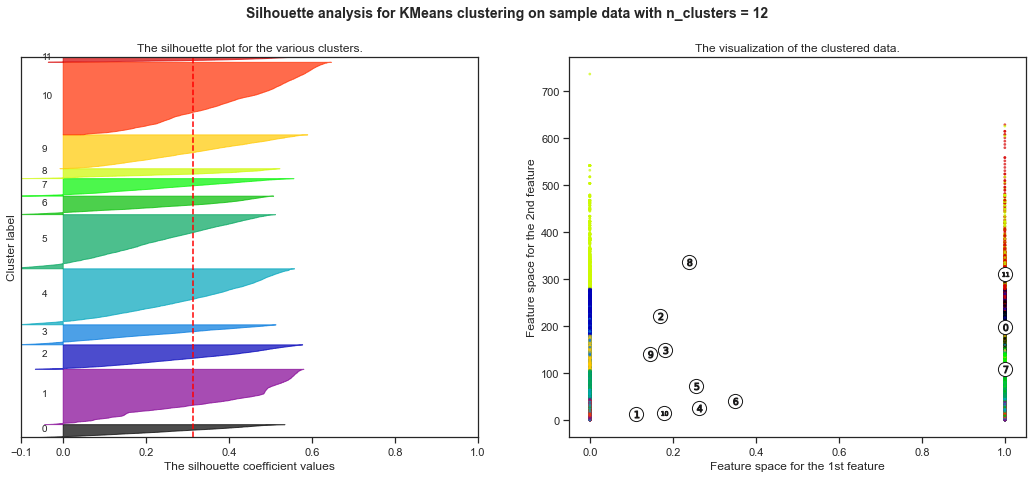

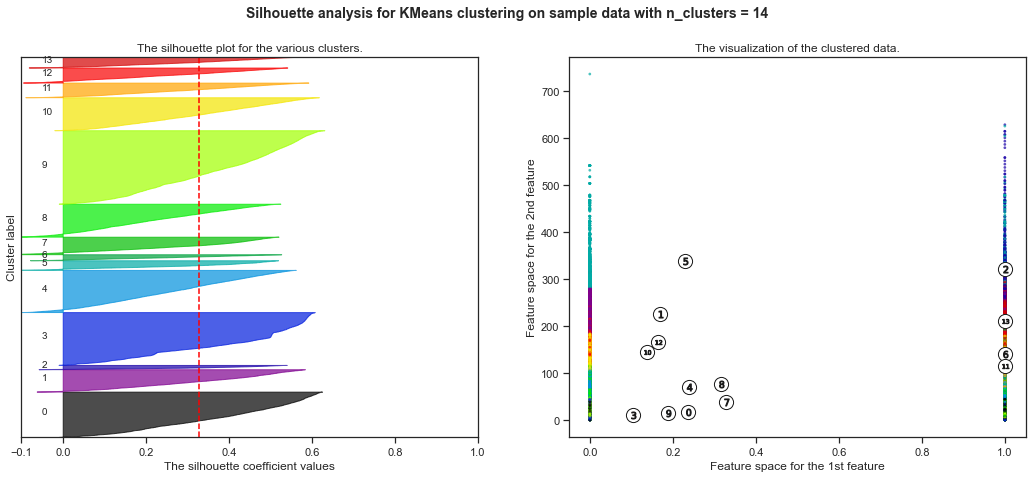

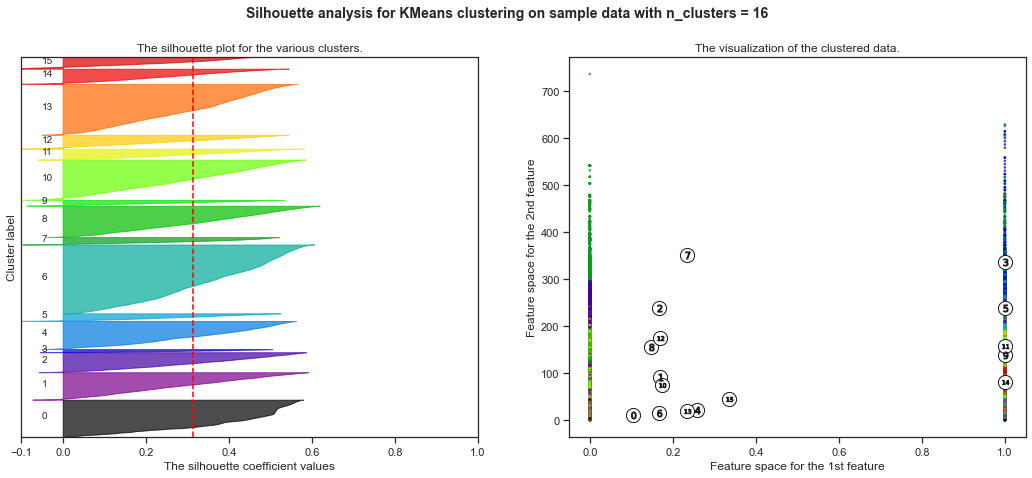

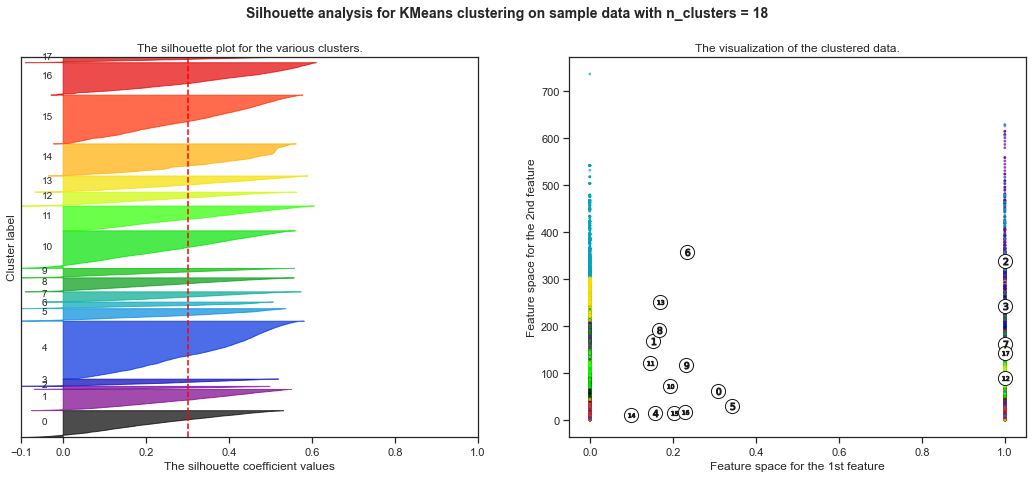

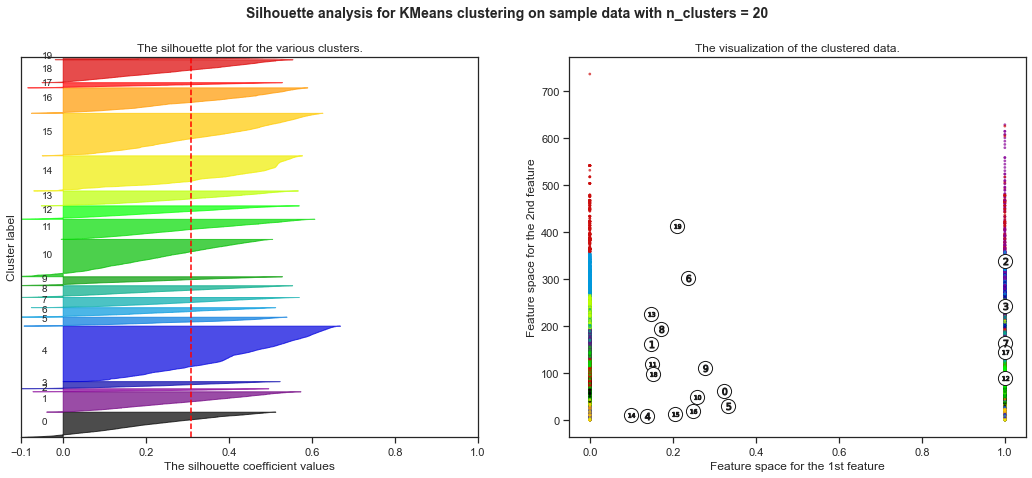

In [210]:
dist = []

for n_clusters in range(2,21,2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(pca_train) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=SEED)
    cluster_labels = clusterer.fit_predict(pca_train)
    dist.append(clusterer.inertia_)
    silhouette_avg = silhouette_score(pca_train, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(pca_train, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        pca_train.iloc[:, 0], pca_train.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

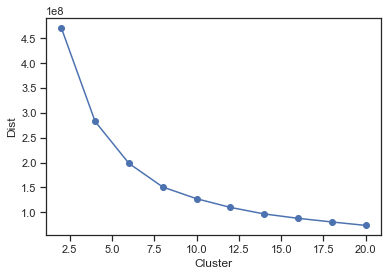

In [213]:
plt.plot(range(2,21,2), dist, marker='o')
plt.xlabel('Cluster')
plt.ylabel('Dist')
plt.show()

In [229]:
clusterer = KMeans(n_clusters= 8 , random_state=SEED)
cluster_train = clusterer.fit_predict(pca_train)
cluster_test = clusterer.predict(pca_test)

In [235]:
pca_train['cluster'] = cluster_train
pca_train.groupby('cluster').mean()

,is_canceled,lead_time,arrival_date_month_number,total_night,arrival_day_in_week,meal_map,deposit_map,booking_binary,parking_binary,request_binary,...,market_Online TA,market_Undefined,cont_AFRICA,cont_ANTARCTICA,cont_ASIA,cont_EU,cont_N.USA,cont_OCEANIA,cont_S.USA,cont_UNK
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.276428,89.536605,6.264399,4.079742,3.100932,0.955389,0.020075,0.168725,0.052975,0.522823,...,0.625508,0.000000,0.007488,0.000000,0.029236,0.888871,0.015693,0.005337,0.030033,0.023341
1,1.000000,149.168210,6.721193,4.600051,3.045782,0.987397,0.094393,0.086163,0.000000,0.350566,...,0.839249,0.000000,0.010545,0.000000,0.021605,0.887088,0.012603,0.006944,0.038837,0.022377
2,0.249436,22.225926,6.647895,2.915925,3.028888,0.923961,0.005910,0.155399,0.091446,0.557577,...,0.708925,0.000000,0.017333,0.000066,0.051600,0.841214,0.014876,0.007039,0.036459,0.031412
3,0.219108,302.738854,7.408917,5.142357,3.004140,1.156051,0.081847,0.323567,0.052866,0.496497,...,0.366879,0.000000,0.005732,0.000000,0.007962,0.924204,0.021656,0.014013,0.013694,0.012739
4,0.328328,52.841676,7.160363,3.830367,3.057286,1.262329,0.004264,0.220245,0.146088,0.590842,...,0.741565,0.000000,0.017798,0.000000,0.032258,0.857990,0.015758,0.005933,0.029292,0.040971
5,0.147622,178.430633,6.935480,4.896584,2.987881,1.081833,0.022392,0.240305,0.081256,0.578486,...,0.562558,0.000000,0.002886,0.000000,0.013389,0.912627,0.025623,0.004848,0.021006,0.019621
6,1.000000,280.021944,7.060188,5.055172,3.080878,1.043260,0.245768,0.097806,0.000000,0.373668,...,0.749843,0.000000,0.004389,0.000000,0.012539,0.900940,0.009404,0.008777,0.049530,0.014420
7,0.142637,15.530660,5.824754,2.706419,2.826702,0.927502,0.007281,0.172221,0.112336,0.407763,...,0.421401,0.000103,0.013484,0.000051,0.024149,0.902225,0.007537,0.002461,0.021073,0.029020


In [257]:
with open(os.path.join(PATH,'models','clusterer.pickle'), "wb") as output_file:
    pickle.dump(clusterer, output_file)


|cluster|proportion|cancellation|lead time|arrival month|arrival week|total stay|meal|deposit|booking_changes|parking|special request|lead time to cancellation|daily_rate|have children or babies|total guest|hotel|room type|customer_type|market segment|continent|
|-------|----------|------------|---------|-------------|------------|----------|----|-------|---------------|-------|---------------|-------------------------|----------|-----------------------|-----------|-----|---------|-------------|--------------|---------|
|0      |28%       | unlikely   |~3 mths  | June        | Fri        | 3        | 1  | No    | 0             | 0     |Yes            |~.33 mths                |~92       |No                     |2          |City |A        |Transient    |mostly online |mostly EU|
|1      |22%       | likely     |~5 mths  | June        | Fri        | 3        | 1  | No    | 0             | 0     |No             |~4 mths                  |~127      |No                     |2          |City |A        |Transient    |mostly online |mostly EU|
|2      |18%       | unlikely   |~.75 mth | June        | Thu        | 3        | 1  | No    | 0             | 0     |Yes            |~4 days                  |~133      |No                     |2          |City |A        |Transient    |mostly online |mostly EU|
|3      |12%       | unlikely   |~10 mths | July        | Sat        | 3        | 1  | No    | 0             | 0     |Uncertain      |~.33 mths                |~89       |No                     |2          |Both |A        |Not Transient|grp+off+online|mostly EU|
|4      |8%        | unlikely   |~2 mths  | July        | Fri        | 3        | 1  | No    | 0             | 0     |Yes            |~.33 mths                |~217      |Likely                 |3          |Both |Others   |Transient    |direct+online |mostly EU|
|5      |6%        | unlikely   |~6 mths  | June        | Sat        | 3        | 1  | No    | 0             | 0     |Yes            |~3 days                  |~109      |No                     |2          |City |A        |Transient    |off+online    |mostly EU|
|6      |4%        | likely     |~9 mths  | July        | Sat        | 3        | 1  | No    | 0             | 0     |No             |~8 mths                  |~106      |No                     |2          |City |A        |Transient    |mostly online |mostly EU|
|7      |2%        | unlikely   |~.5 mth  | June        | Thu        | 3        | 1  | No    | 0             | 0     |No             |~1 day                   |~62       |No                     |2          |Both |A        |Transient    |mostly online |mostly EU|

#### Q5. Classification

In [277]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report

In [305]:
class preClassification(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.hotel_enc = OrdinalEncoder()
        self.continent_enc = OneHotEncoder(handle_unknown='ignore')
        self.meal_map = {'BB':1,'FB':3,'HB':2,'SC':0,'Undefined':-1}
        self.market_enc = OneHotEncoder(handle_unknown='ignore')
        # self.dist_enc = OneHotEncoder(handle_unknown='ignore')
        self.booking_enc = Binarizer()
        self.room_map = {'C':1, 'A':0, 'D':1, 'E':1, 'G':1, 
        'F':1, 'I':1, 'B':1, 'H':1, 'P':1, 'L':1, 'K':1}
        # self.room_enc = OneHotEncoder(handle_unknown='ignore')
        self.deposit_map = {'No Deposit':0, 'Non Refund':2, 'Refundable':1}
        self.customer_map = {'Transient':0, 'Contract':1, 'Transient-Party':1, 'Group':1}
        # self.customer_enc = OneHotEncoder(handle_unknown='ignore')
        self.request_enc = Binarizer()
        self.parking_enc = Binarizer()
        self.columns = ['hotel','continent','meal','lead_time',
        'market_segment','distribution_channel','booking_changes',
        'reserved_room_type','deposit_type','customer_type','have_dependent',
        'total_of_special_requests',
        'required_car_parking_spaces','adr','booking_month','arrival_date_week_number',
        'arrival_date_month_number','total_night','stays_in_week_nights',
        'stays_in_weekend_nights','total_guest']

    def fit(self, X: pd.DataFrame):
        self.X = X 
        assert len(set(self.columns) - set(self.X.columns)) == 0
        self.X['continent'] = self.X.continent.fillna('UNK')
        self.X['lead_time_to_cancel'] = self.X.lead_time_to_cancel.fillna(-1)
        self.hotel_enc.fit(self.X.hotel.values.reshape(-1,1))
        self.continent_enc.fit(self.X.continent.values.reshape(-1,1))
        self.market_enc.fit(self.X.market_segment.values.reshape(-1,1))
        # self.dist_enc.fit(self.X.distribution_channel.values.reshape(-1,1))
        self.booking_enc.fit(self.X.booking_changes.values.reshape(-1,1))
        # self.room_enc.fit(self.X.assigned_room_type.values.reshape(-1,1))
        # self.customer_enc.fit(self.X.customer_type.values.reshape(-1,1))
        self.request_enc.fit(self.X.total_of_special_requests.values.reshape(-1,1))
        self.parking_enc.fit(self.X.required_car_parking_spaces.values.reshape(-1,1))

    def transform(self, X:pd.DataFrame, y=None):
        assert len(set(self.columns) - set(X.columns)) == 0
        X['lead_time'] = np.log(X['lead_time']+1)
        X['adr'] = np.log(X['adr']+7)
        X['total_night'] = np.log(X['total_night']+1)

        X['continent'] = X.continent.fillna('UNK')
        X['lead_time_to_cancel'] = X.lead_time_to_cancel.fillna(-1)
        X['meal_map'] = X.meal.map(self.meal_map)
        X['deposit_map'] = X.deposit_type.map(self.deposit_map)
        X['room_binary'] = X.reserved_room_type.map(self.room_map)
        X['cust_binary'] = X.customer_type.map(self.customer_map)
        X['booking_binary'] = self.booking_enc.transform(X.booking_changes.values.reshape(-1,1))
        X['parking_binary'] = self.parking_enc.transform(X.required_car_parking_spaces.values.reshape(-1,1))
        X['request_binary'] = self.request_enc.transform(X.total_of_special_requests.values.reshape(-1,1))
        X['hotel_binary'] = self.hotel_enc.transform(X.hotel.values.reshape(-1,1))
        market_arr = self.market_enc.transform(X.market_segment.values.reshape(-1,1)).toarray()
        # dist_arr = self.dist_enc.transform(X.distribution_channel.values.reshape(-1,1)).toarray()
        # room_arr = self.room_enc.transform(X.assigned_room_type.values.reshape(-1,1)).toarray()
        # cust_arr = self.customer_enc.transform(X.customer_type.values.reshape(-1,1)).toarray()
        continent_arr = self.continent_enc.transform(X.continent.values.reshape(-1,1)).toarray()
        
        return pd.DataFrame(np.hstack((X[['lead_time','arrival_date_month_number','total_night',
        'meal_map','deposit_map','booking_binary', 'booking_month','arrival_date_week_number',
        'parking_binary','request_binary','adr','have_dependent','total_guest',
        'hotel_binary','room_binary','cust_binary']], market_arr, continent_arr)),
        columns = ['lead_time','arrival_date_month_number','total_night',
        'meal_map','deposit_map','booking_binary', 'booking_month','arrival_date_week_number', 'parking_binary',
        'request_binary','adr','have_dependent','total_guest',
        'hotel_binary','room_binary','cust_binary'] + ['market_'+c for c in self.market_enc.categories_[0]] + 
        ['cont_'+c for c in self.continent_enc.categories_[0]]
        )


In [306]:
train_X, train_y = train_df.drop('is_canceled',axis=1),train_df.is_canceled
test_X, test_y = test_df.drop('is_canceled',axis=1),test_df.is_canceled

In [307]:
pre_clf = preClassification()
pre_clf.fit(train_X)
train_X = pre_clf.transform(train_X)
test_X = pre_clf.transform(test_X)

In [308]:
clf_p1 = Pipeline(steps=[('scale',StandardScaler()),('clf', LogisticRegression(random_state=SEED))])
clf_p1.fit(train_X, train_y)

Pipeline(steps=[('scale', StandardScaler()), ('clf', LogisticRegression())])

In [309]:
print(clf_p1.score(train_X, train_y))
print(clf_p1.score(test_X, test_y))

0.7883403060347298
0.7917478510028654


In [310]:
print(classification_report(test_y,clf_p1.predict(test_X) ))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87     12654
           1       0.70      0.42      0.53      4796

    accuracy                           0.79     17450
   macro avg       0.76      0.68      0.70     17450
weighted avg       0.78      0.79      0.77     17450



In [311]:
importance = clf_p1.named_steps['clf'].coef_[0]
pd.DataFrame({'col':train_X.columns,'importance':importance}).sort_values(by='importance')

,col,importance
8,parking_binary,-2.293285
9,request_binary,-0.573160
21,market_Offline TA/TO,-0.349763
5,booking_binary,-0.294826
15,cust_binary,-0.244517
7,arrival_date_week_number,-0.109441
28,cont_N.USA,-0.083040
19,market_Direct,-0.076788
20,market_Groups,-0.056743
31,cont_UNK,-0.053329


In [312]:
clf_p2 = DecisionTreeClassifier(random_state=SEED)
clf_p2.fit(train_X, train_y)
print(classification_report(test_y,clf_p2.predict(test_X) ))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82     12654
           1       0.54      0.55      0.54      4796

    accuracy                           0.75     17450
   macro avg       0.68      0.69      0.68     17450
weighted avg       0.75      0.75      0.75     17450



In [313]:
clf_p3 = GradientBoostingClassifier(random_state=SEED)
clf_p3.fit(train_X, train_y)
print(classification_report(test_y,clf_p3.predict(test_X) ))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87     12654
           1       0.71      0.42      0.53      4796

    accuracy                           0.79     17450
   macro avg       0.76      0.68      0.70     17450
weighted avg       0.78      0.79      0.77     17450



In [314]:
clf_p4 = RandomForestClassifier(random_state=SEED)
clf_p4.fit(train_X, train_y)
print(classification_report(test_y,clf_p4.predict(test_X) ))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87     12654
           1       0.68      0.52      0.59      4796

    accuracy                           0.80     17450
   macro avg       0.76      0.72      0.73     17450
weighted avg       0.79      0.80      0.79     17450



In [318]:
pd.DataFrame({'col':train_X.columns,'importance':clf_p4.feature_importances_}).sort_values(by='importance')

,col,importance
25,cont_ANTARCTICA,0.000002
23,market_Undefined,0.000085
16,market_Aviation,0.000377
17,market_Complementary,0.000627
29,cont_OCEANIA,0.001062
28,cont_N.USA,0.002056
18,market_Corporate,0.002739
24,cont_AFRICA,0.002922
31,cont_UNK,0.003095
30,cont_S.USA,0.003436


In [317]:
with open(os.path.join(PATH,'models','clf_rf.pickle'),'wb') as output_file:
    pickle.dump(clf_p4, output_file)

with open(os.path.join(PATH,'models','clf_lr.pickle'),'wb') as output_file:
    pickle.dump(clf_p1, output_file)

#### Q6. Regression

In [365]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score 

In [316]:
class preRegressor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.hotel_enc = OrdinalEncoder()
        self.continent_enc = OneHotEncoder(handle_unknown='ignore')
        self.meal_map = {'BB':1,'FB':3,'HB':2,'SC':0,'Undefined':-1}
        self.market_enc = OneHotEncoder(handle_unknown='ignore')
        # self.dist_enc = OneHotEncoder(handle_unknown='ignore')
        
        self.room_map = {'C':1, 'A':0, 'D':1, 'E':1, 'G':1, 
        'F':1, 'I':1, 'B':1, 'H':1, 'P':1, 'L':1, 'K':1}
        # self.room_enc = OneHotEncoder(handle_unknown='ignore')
        self.deposit_map = {'No Deposit':0, 'Non Refund':2, 'Refundable':1}
        self.customer_map = {'Transient':0, 'Contract':1, 'Transient-Party':1, 'Group':1}
        # self.customer_enc = OneHotEncoder(handle_unknown='ignore')
        self.request_enc = Binarizer()
        self.parking_enc = Binarizer()
        self.columns = ['hotel','continent','meal','lead_time',
        'market_segment','distribution_channel',
        'reserved_room_type','deposit_type','customer_type','have_dependent',
        'total_of_special_requests','arrival_day_in_week',
        'required_car_parking_spaces','adr','booking_month','arrival_date_week_number',
        'arrival_date_month_number','total_guest']

    def fit(self, X: pd.DataFrame):
        self.X = X 
        assert len(set(self.columns) - set(self.X.columns)) == 0
        self.X['continent'] = self.X.continent.fillna('UNK')
        self.hotel_enc.fit(self.X.hotel.values.reshape(-1,1))
        self.continent_enc.fit(self.X.continent.values.reshape(-1,1))
        self.market_enc.fit(self.X.market_segment.values.reshape(-1,1))
        # self.dist_enc.fit(self.X.distribution_channel.values.reshape(-1,1))
        
        # self.room_enc.fit(self.X.assigned_room_type.values.reshape(-1,1))
        # self.customer_enc.fit(self.X.customer_type.values.reshape(-1,1))
        self.request_enc.fit(self.X.total_of_special_requests.values.reshape(-1,1))
        self.parking_enc.fit(self.X.required_car_parking_spaces.values.reshape(-1,1))

    def transform(self, X:pd.DataFrame, y=None):
        assert len(set(self.columns) - set(X.columns)) == 0
        X['lead_time'] = np.log(X['lead_time']+1)
        X['adr'] = np.log(X['adr']+7)
        X['continent'] = X.continent.fillna('UNK')
        X['meal_map'] = X.meal.map(self.meal_map)
        X['deposit_map'] = X.deposit_type.map(self.deposit_map)
        X['room_binary'] = X.reserved_room_type.map(self.room_map)
        X['cust_binary'] = X.customer_type.map(self.customer_map)
        X['parking_binary'] = self.parking_enc.transform(X.required_car_parking_spaces.values.reshape(-1,1))
        X['request_binary'] = self.request_enc.transform(X.total_of_special_requests.values.reshape(-1,1))
        X['hotel_binary'] = self.hotel_enc.transform(X.hotel.values.reshape(-1,1))
        market_arr = self.market_enc.transform(X.market_segment.values.reshape(-1,1)).toarray()
        # dist_arr = self.dist_enc.transform(X.distribution_channel.values.reshape(-1,1)).toarray()
        # room_arr = self.room_enc.transform(X.assigned_room_type.values.reshape(-1,1)).toarray()
        # cust_arr = self.customer_enc.transform(X.customer_type.values.reshape(-1,1)).toarray()
        continent_arr = self.continent_enc.transform(X.continent.values.reshape(-1,1)).toarray()
        return pd.DataFrame(np.hstack((X[['lead_time','arrival_date_month_number','arrival_date_week_number',
        'meal_map','deposit_map', 'booking_month',
        'parking_binary','request_binary','adr','have_dependent','total_guest','arrival_day_in_week',
        'hotel_binary','room_binary','cust_binary']], market_arr, continent_arr)),
        columns = ['lead_time','arrival_date_month_number','arrival_date_week_number',
        'meal_map','deposit_map','booking_month', 'parking_binary',
        'request_binary','adr','have_dependent','total_guest','arrival_day_in_week',
        'hotel_binary','room_binary','cust_binary'] + ['market_'+c for c in self.market_enc.categories_[0]] + 
        ['cont_'+c for c in self.continent_enc.categories_[0]]
        )


In [330]:
X_train, X_test, y_train, y_test = train_test_split(df_pca.drop('total_night', axis=1), df_pca.total_night, random_state = SEED, test_size=0.2)

In [332]:
pre_reg = preRegressor()
pre_reg.fit(X_train)
X_train = pre_reg.transform(X_train)
X_test = pre_reg.transform(X_test)

In [341]:
y_train, y_test = np.log(y_train+1), np.log(y_test+1)

In [353]:
reg_p1 = Pipeline(steps = [('scaler',StandardScaler()),('reg',LinearRegression())])
reg_p1.fit(X_train, y_train)
reg_p1.score(X_test, y_test)

0.31003699601291745

In [354]:
mean_squared_error(y_test, reg_p1.predict(X_test))

0.17927591970655601

In [359]:
pd.DataFrame({'col':X_train.columns, 'importance':reg_p1.named_steps['reg'].coef_}).sort_values(by='importance')

,col,importance
26,cont_EU,-4.624541e+12
25,cont_ASIA,-2.435070e+12
29,cont_S.USA,-2.385735e+12
30,cont_UNK,-2.339484e+12
27,cont_N.USA,-1.726303e+12
23,cont_AFRICA,-1.545742e+12
28,cont_OCEANIA,-1.065282e+12
21,market_Online TA,-9.351459e+11
20,market_Offline TA/TO,-6.954541e+11
18,market_Direct,-6.498132e+11


In [360]:
reg_p2 = RandomForestRegressor(random_state=SEED)
reg_p2.fit(X_train, y_train)
print(reg_p2.score(X_test, y_test))
print(mean_squared_error(y_test, reg_p2.predict(X_test)))

0.4948102601170167
0.1312655239780556


In [362]:
reg_p3 = GradientBoostingRegressor(random_state=SEED)
reg_p3.fit(X_train, y_train)
print(reg_p3.score(X_test, y_test))
print(mean_squared_error(y_test, reg_p3.predict(X_test)))

0.38771039634749305
0.15909372123903173


In [366]:
reg_p4 = Pipeline(steps = [('scaler',StandardScaler()),('reg',LinearSVR(random_state=SEED, C=.1))])
reg_p4.fit(X_train, y_train)
print(reg_p4.score(X_test, y_test))
print(mean_squared_error(y_test, reg_p4.predict(X_test)))

0.3022092720445335
0.18130982935900364


In [368]:
pd.DataFrame({'col':X_train.columns, 'importance':reg_p2.feature_importances_}).sort_values(by='importance')

,col,importance
24,cont_ANTARCTICA,8.844463e-07
22,market_Undefined,1.294035e-06
28,cont_OCEANIA,1.316452e-03
15,market_Aviation,1.390402e-03
4,deposit_map,1.441754e-03
27,cont_N.USA,2.457046e-03
25,cont_ASIA,3.867099e-03
16,market_Complementary,3.971735e-03
30,cont_UNK,4.206313e-03
29,cont_S.USA,4.650392e-03


In [370]:
with open(os.path.join(PATH,'models','reg_lr.pickle'),'wb') as output_file:
    pickle.dump(reg_p1, output_file)

with open(os.path.join(PATH,'models','reg_rf.pickle'),'wb') as output_file:
    pickle.dump(reg_p2, output_file)   

### References

[1] https://www.sciencedirect.com/science/article/pii/S2352340918315191 <br/>
[2] https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md 